HEre we run VGG alike structure of CNN without data agumentation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
from pathlib import Path

#torch 
import torch
import torchvision as torchv
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import Tensor
from torch.utils import data

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

In [2]:
#Metode for å hente data frå mappe
module_path = str(Path.cwd().parents[0].parents[0] / "methods")

if module_path not in sys.path:
    sys.path.append(module_path)

from dataloader import *
# from plotCreator import *

data_path0 = str(Path.cwd().parents[0].parents[0] / "data" / "BH_n4_M10_res50_15000_events.h5")
data_path1 = str(Path.cwd().parents[0].parents[0] / "data" / "PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_res50_15000_events.h5")

In [3]:
#Hente data og sette til array
bhArray = dataToArray(data_path0)
sphArray = dataToArray(data_path1)

In [4]:
#Kombinerer dataene for å kunne kjøre gjennom modellen på et samlet datasett
dataArray = np.concatenate((bhArray,sphArray),axis=0)

In [5]:
# Labeler tabelle med 1 og 0 (0 = svart hull, 1 = spahleron)
labelsArray = np.concatenate((np.zeros(np.shape(bhArray)[0]),np.ones(np.shape(sphArray)[0])),axis=0)

In [6]:
#Sjekke om device GPU er på
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [7]:
#Split data 75% i train og 25% i test
trainData, testData, trainLabels, testLabels = train_test_split(dataArray, labelsArray, random_state=42)

In [8]:
#Transofrm from numpy array to torch
trainData = torch.from_numpy(trainData).permute(0,3,1,2)
testData = torch.from_numpy(testData).permute(0,3,1,2)
trainLabels = torch.from_numpy(trainLabels)
testLabels = torch.from_numpy(testLabels)

In [9]:
#Transformere numpy til tensor
train = torch.utils.data.TensorDataset(trainData, trainLabels)
test = torch.utils.data.TensorDataset(testData, testLabels)

In [10]:
#Transform data data to dataloader
trainLoader = DataLoader(train, shuffle=True, batch_size=50)
testLoader = DataLoader(test, shuffle=True, batch_size=50)

In [11]:
from torchsummary import summary
import nnmodel

model = nnmodel.VGGNet(0.5).to(device)  # Move the model to the appropriate device

# Print the model summary, make sure to provide appropriate input size (3, 50, 50) for the 3-channel 50x50 images
summary(model, (3, 50, 50))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 50, 50]           1,792
       BatchNorm2d-2           [-1, 64, 50, 50]             128
              ReLU-3           [-1, 64, 50, 50]               0
            Conv2d-4           [-1, 64, 50, 50]          36,928
       BatchNorm2d-5           [-1, 64, 50, 50]             128
              ReLU-6           [-1, 64, 50, 50]               0
         MaxPool2d-7           [-1, 64, 25, 25]               0
           Dropout-8           [-1, 64, 25, 25]               0
            Conv2d-9          [-1, 128, 25, 25]          73,856
      BatchNorm2d-10          [-1, 128, 25, 25]             256
             ReLU-11          [-1, 128, 25, 25]               0
           Conv2d-12          [-1, 128, 25, 25]         147,584
      BatchNorm2d-13          [-1, 128, 25, 25]             256
             ReLU-14          [-1, 128,

Koden under utfører treningen og plotter alt i noen utvalgte grafer, må ryddes i for å få bedre oversikt!

Running on the GPU
Epoch: 1/15
Train Loss: 0.3791, Train Accuracy: 87.38%
Test Loss: 0.3820, Test Accuracy: 83.72%
Epoch: 2/15
Train Loss: 0.2238, Train Accuracy: 91.43%
Test Loss: 0.2730, Test Accuracy: 88.65%
Epoch: 3/15
Train Loss: 0.2143, Train Accuracy: 91.65%
Test Loss: 0.3034, Test Accuracy: 87.03%
Epoch: 4/15
Train Loss: 0.2030, Train Accuracy: 92.39%
Test Loss: 0.2490, Test Accuracy: 90.00%
Epoch: 5/15
Train Loss: 0.2013, Train Accuracy: 92.37%
Test Loss: 0.2058, Test Accuracy: 91.41%
Epoch: 6/15
Train Loss: 0.2238, Train Accuracy: 91.90%
Test Loss: 0.1920, Test Accuracy: 92.35%
Epoch: 7/15
Train Loss: 0.1903, Train Accuracy: 92.56%
Test Loss: 0.2073, Test Accuracy: 91.83%
Epoch: 8/15
Train Loss: 0.1837, Train Accuracy: 92.93%
Test Loss: 0.1761, Test Accuracy: 93.17%
Epoch: 9/15
Train Loss: 0.1849, Train Accuracy: 93.15%
Test Loss: 0.1711, Test Accuracy: 93.37%
Epoch: 10/15
Train Loss: 0.1803, Train Accuracy: 92.97%
Test Loss: 0.1659, Test Accuracy: 93.64%
Epoch: 11/15
Train L

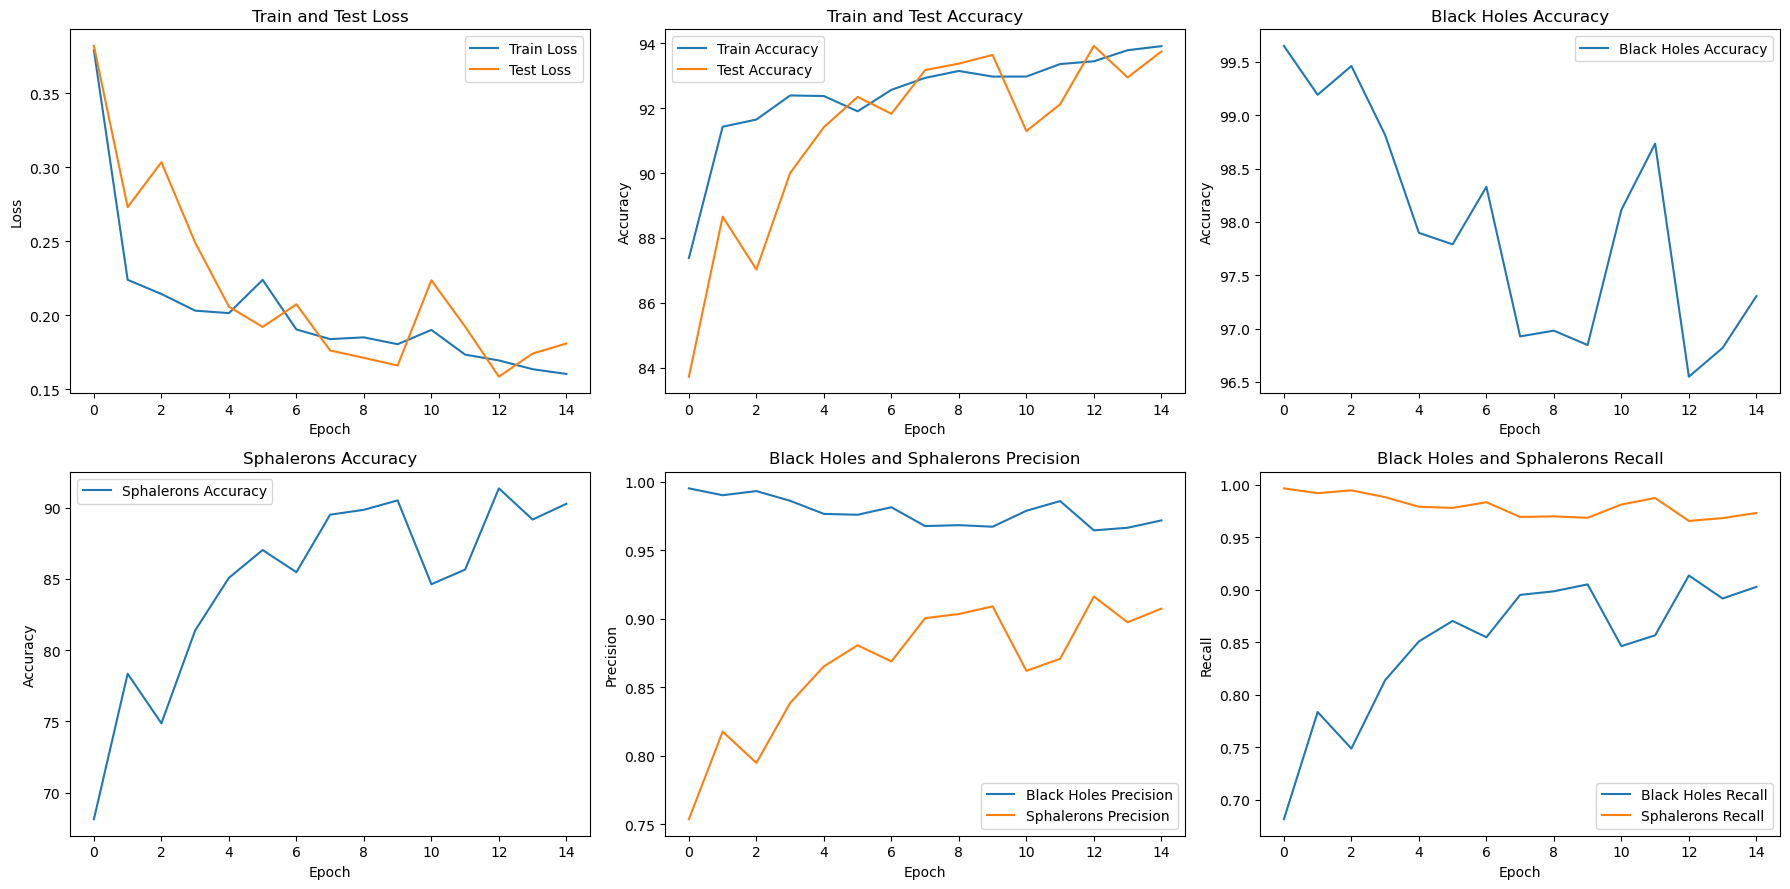

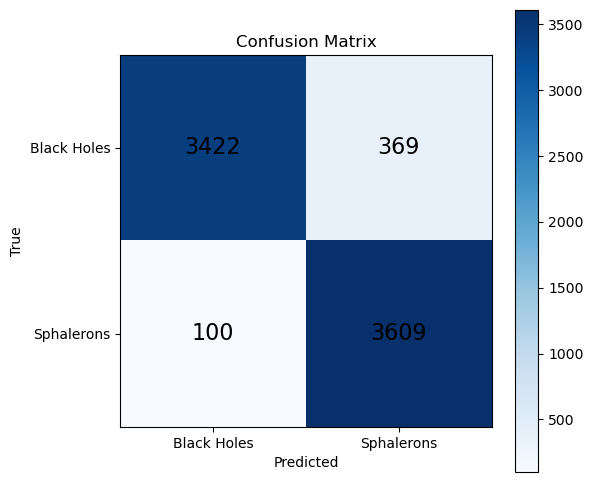

In [12]:
import trainer
#Set the learning rate and number of epochs
n_epochs = 15

# Create the model
model = nnmodel.VGGNet(0.5).to(device)

# Set up the optimizer and criterion
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss().to(device)

# Train the model
trainer.train(model, trainLoader, testLoader, optimizer, criterion, n_epochs)

Code below makes it possible to save model

In [13]:
# Define the file path to save the trained model
# model_path = 'model.pth'

# Train and save the model
# train(model, train_loader, test_loader, optimizer, criterion, n_epochs)
# torch.save(model.state_dict(), model_path)

In [14]:
# # Define the file path to load the saved model
# model_path = 'model.pth'

# # Create an instance of the model and load the saved state dictionary
# model = SymmetricNet(dropout=0.25)
# model.load_state_dict(torch.load(model_path))